# Patient Similarity

In this notebook we will explore using vectors to represent patients based on their ICD9 codes and then use vector operations to compute similarity between patients. The vectors will typically be sparse so we will explore using 
dictionaries to represent sparse vectors.

## vector norm 
[reference](http://mathworld.wolfram.com/VectorNorm.html)

In [1]:
import pymysql
import pandas as pd

import getpass
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.linalg import norm
from collections import defaultdict
import itertools

In [40]:
from myla.becvector import *

In [5]:
conn = pymysql.connect(host="mysql",
                       port=3306,user="jovyan",
                       passwd=getpass.getpass("Enter MySQL passwd for jovyan"),db='mimic2')
cursor = conn.cursor()

Enter MySQL passwd for jovyan ······


In [6]:
pd.read_sql('SELECT * from icd9',conn).head()


,subject_id,hadm_id,sequence,code,description
0,56,28766,1,198.3,SECONDARY MALIGNANT NEOPLASM OF BRAIN AND SPIN...
1,56,28766,2,162.8,MALIGNANT NEOPLASM OF OTHER PARTS OF BRONCHUS ...
2,56,28766,3,531.40,CHRONIC OR UNSPECIFIED GASTRIC ULCER WITH HEMO...
3,56,28766,4,276.1,HYPOSMOLALITY AND/OR HYPONATREMIA
4,56,28766,5,428.0,CONGESTIVE HEART FAILURE UNSPECIFIED


In [7]:
icd9_codes = pd.read_sql('SELECT subject_id, code, description from icd9',conn)
icd9_codes.head()

,subject_id,code,description
0,56,198.3,SECONDARY MALIGNANT NEOPLASM OF BRAIN AND SPIN...
1,56,162.8,MALIGNANT NEOPLASM OF OTHER PARTS OF BRONCHUS ...
2,56,531.40,CHRONIC OR UNSPECIFIED GASTRIC ULCER WITH HEMO...
3,56,276.1,HYPOSMOLALITY AND/OR HYPONATREMIA
4,56,428.0,CONGESTIVE HEART FAILURE UNSPECIFIED


### We need to ...

1. get the unique ICD9 codes
2. Create a vocabulary that maps a code to a dimension in our vector space.
3. Create a map from the code to the description to make things more human friendly

### The shape of icd9_code

In [20]:
icd9_codes.shape

(53486, 3)

### The number of Patient

In [21]:
len(icd9_codes.subject_id.unique())

3951

In [22]:
voc_code = icd9_codes.code.unique()
voc_code.sort()

In [23]:
len(voc_code)

2719

In [24]:
code_map = dict(zip(icd9_codes.code, icd9_codes.description))
len(code_map)

2719

In [25]:
voc_map = dict((voc_code[i], i) for i in range(len(voc_code)))
dim = len(voc_map)
dim

2719

### Get a List of ICD9 codes for each patient

In [26]:
demo = defaultdict(list)
demo

defaultdict(list, {})

In [27]:
demo["Brian"] = "Chapman"
demo["Brian1"].append("Chapman")

In [28]:
demo

defaultdict(list, {'Brian': 'Chapman', 'Brian1': ['Chapman']})

In [30]:
patients = defaultdict(list)
for _,row in icd9_codes.iterrows():
    patients[row["subject_id"]].append(row["code"])

In [31]:
min([len(patients[k]) for k in patients]), max([len(patients[k]) for k in patients]), np.mean([len(patients[k]) for k in patients])

(1, 308, 13.53733232093141)

In [32]:
def patient2vec(p, vmap):
    """
    takes a patient p and a vocabulary vmap and returns a vector representation of p
    """
    pv = zero(len(vmap))
    for code in p:
        pv[vmap[code]] += 1
    return pv

In [33]:
v56 = patient2vec(patients[56],voc_map)
sum([1 for i in v56 if i != 0])
type(v56)

list

In [36]:
patient_vectors = {p:patient2vec(patients[p], voc_map) for p in patients}

In [51]:
len(patient_vectors)

3951

In [54]:
norm(patient2vec(patients[56],voc_map))

2.8284271247461903

### Cosine Similarity
One of the simplest ways of comparing two texts is with the [cosine similarity measure](https://en.wikipedia.org/wiki/Cosine_similarity). The sentences with the smallest angle between them are the most similar.

![angle between two vectors](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Dot_Product.svg/200px-Dot_Product.svg.png)

---------------

$$\cos{\theta} = \frac{\vec{A}\cdot\vec{B}}{{\left|\left|\vec{A}\right|\right|}{\left|\left|\vec{B}\right|\right|}}$$
    

In [41]:
def cos_sim(v1, v2):
    return dot(v1,v2) / (norm(v1) * norm(v2))

In [4]:
cos_sim([1,2], [2,1])

0.7999999999999998

In [43]:
similarities = {}

In [44]:
import random
keys = list(patient_vectors.keys())
random.shuffle(keys)
use_keys = keys[0:50]

for p1 in use_keys:
    v1 = patient_vectors[p1]
    for p2 in use_keys:
        v2 = patient_vectors[p2]
        similarities[(p1, p2)] = cos_sim(v1, v2)


In [46]:
similarities

{(13995, 13995): 0.9999999999999998,
 (13995, 8581): 0.0753778361444409,
 (13995, 2828): 0.18257418583505533,
 (13995, 18885): 0.0944911182523068,
 (13995, 22664): 0.0,
 (13995, 25672): 0.0,
 (13995, 13252): 0.0,
 (13995, 5603): 0.0,
 (13995, 1610): 0.0,
 (13995, 10940): 0.0,
 (13995, 8927): 0.1178511301977579,
 (13995, 6704): 0.0,
 (13995, 21830): 0.0,
 (13995, 28456): 0.0,
 (13995, 17980): 0.10660035817780521,
 (13995, 16993): 0.0,
 (13995, 13186): 0.07905694150420949,
 (13995, 32131): 0.0,
 (13995, 27983): 0.0,
 (13995, 29893): 0.07071067811865475,
 (13995, 20485): 0.0944911182523068,
 (13995, 2127): 0.1178511301977579,
 (13995, 4622): 0.0,
 (13995, 24912): 0.0,
 (13995, 21979): 0.0944911182523068,
 (13995, 16727): 0.0,
 (13995, 22508): 0.1178511301977579,
 (13995, 342): 0.1178511301977579,
 (13995, 24603): 0.09128709291752767,
 (13995, 4967): 0.0,
 (13995, 31714): 0.12499999999999997,
 (13995, 13033): 0.0,
 (13995, 19946): 0.18257418583505533,
 (13995, 17808): 0.13363062095621217,


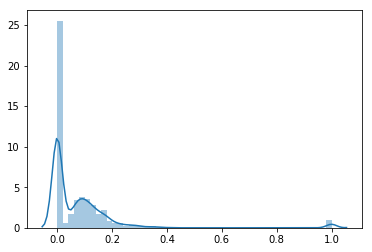

In [54]:
sns.distplot(list(similarities.values()))

In [52]:
help(sns)

Help on package seaborn:

NAME
    seaborn - # Capture the original matplotlib rcParams

PACKAGE CONTENTS
    algorithms
    apionly
    axisgrid
    categorical
    cm
    colors (package)
    conftest
    distributions
    external (package)
    linearmodels
    matrix
    miscplot
    palettes
    rcmod
    regression
    relational
    tests (package)
    timeseries
    utils
    widgets

DATA
    crayons = {'Almond': '#EFDECD', 'Antique Brass': '#CD9575', 'Apricot':...
    xkcd_rgb = {'acid green': '#8ffe09', 'adobe': '#bd6c48', 'algae': '#54...

VERSION
    0.9.0

FILE
    /opt/conda/lib/python3.7/site-packages/seaborn/__init__.py


